### Model performance comparison

In this notebook, we are going to compare performance of many classification models using heart disease dataset.

The basic framework to train a machine learning model using scikit-learn is as follow:
1) Choose the model based on the problem you want to solve, regression or classification.
2) Split the data into train set and test set.
3) Depending on the model selected, you may need to peferom feature scaling
4) Instanciate the model
5) Execute the command model.fit()
6) Exute the command model.predict() to get the predictions from the test set
7) Evaluate the model using performance metrics

In we compare one model against many others, we may end up with a extensive notebook.

The goal here is to automate the workflow to evaluate three or four models at once.

Three ways to fine tuning a model, which means to change the hyperparameters:
1) by hand -  manually input one hyperparameter value per time.
2) RandomizeSearchCV
3) GridSearchCV - use a dictionary with a hyperparameter list of values. That is the one we will use here.

The hyperparameters should be evaluated and changed based on the validation set, and NOT on test set. The test set should be used only at the end, when we are satisfied witht the performance.

According to scikit-learn documentation, there are three ways to measure the model performance:
1) Estimator/algorithm score() method.
2) Using the 'scoring' parameter. This parameter is used in methods like cross_val_score and GridSearchCV. The advantage of it is that we can use many metrics at the same time.
3) Metric functions, from scikit-learn or a custom made function based on specific needs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## MODELS ##
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression 
from sklearn.svm import SVC

## METRICS ##
# classificaton models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# in case you want silence warnings
import warnings
warnings.filterwarnings("ignore") #"default"

C:\Users\alberto.beniste\.conda\envs\alberto_beniste\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Functions

In [2]:
def get_hyperparameters(estimator_name):
    return estimator_name().get_params()

In [3]:
def evaluate_preds(estimator_name, y_true, y_pred, average=None):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels on a classification.
    Parameters:
        y_true: the true value from the dataset
        y_pred: the precitions from the model
        avarage: used in case it is a multi-class classification
    Return:
        metric_dict (dict): it returns a dictionary with the four metrics, used to plot the performance graph.
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    metric_dict = {"model": estimator_name,
                   "accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    
    return metric_dict

In [4]:
def train_evaluate_model(X_train, X_test, y_train, y_test, model_grid, cv=5, verbose=2):
    """
    """
    
    # Create an empty data frame to add the set of metrics for eacg model
    metrics_df = pd.DataFrame()
    
    # Go over the model dictrionary
    for estimator_name, grid_key in model_grid.items():
        # instantiate the estimator
        model = eval(estimator_name + "()")
        
        # grid_search_dict contains the list of hyperparameters
        grid_name, grid_search_dict = next(iter(grid_key.items()))
        grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_search_dict,
                                  cv=cv,
                                  verbose=verbose
                     )
        
        # Now that we have the best model, fit to the data
        grid_model.fit(X_train, y_train)
        
        # Get the predictions to measure the performance
        y_pred = grid_model.predict(X_test)
        
        # calll function with 4 metrics performance
        metric_dict = evaluate_preds(estimator_name=estimator_name, y_true=y_test, y_pred=y_pred)
        metrics_df = pd.concat([metrics_df, pd.DataFrame([metric_dict])], ignore_index=True, keys=estimator_name)
    
    return metrics_df

In [5]:
def plot_metrics(metric_df):
    """
    Plot all four metrics per model
    Parameters:
        metric_df (DataFrame): data frame with the models and their performance metrics
    """
    metric_df.plot.bar(x="model")
    plt.ylabel("Metric")
    plt.xticks(rotation=45)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()


### Dataset

In [7]:
df = pd.read_csv("heart-disease.csv")

In [8]:
df.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


In [9]:
X = df.drop(columns="target")
y = df.target
X.shape, y.shape

((303, 13), (303,))

### Split the data into train and test sets

In [10]:
# We will use only X_train and y_train to train the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

### Create the hyperparameters dictionary per estimator

Here we create the dictionary with all algorithms/estimator with its hyperparameters. Then, we use GridSearchCV to find the best hyperparameters.

In [11]:
grid_model_cv = {
    "RandomForestClassifier": {"grid": {"n_estimators": [2, 5, 10],
                                       }
                              },
    "LogisticRegression": {"grid": {"penalty": ['l1', 'l2'],
                                    "C": [100, 10, 1.0, 0.1, 0.01]
                                   }
                          }
}

In [12]:
grid_model_cv

{'RandomForestClassifier': {'grid': {'n_estimators': [2, 5, 10]}},
 'LogisticRegression': {'grid': {'penalty': ['l1', 'l2'],
   'C': [100, 10, 1.0, 0.1, 0.01]}}}

### Call the function that go over all estimators for each list of hyperparameters

In [13]:
metric_df = train_evaluate_model(X_train, X_test, y_train, y_test, model_grid=grid_model_cv, cv=5, verbose=2)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END .....................................n_estimators=2; total time=   0.0s
[CV] END .....................................n_estimators=2; total time=   0.0s
[CV] END .....................................n_estimators=2; total time=   0.0s
[CV] END .....................................n_estimators=2; total time=   0.0s
[CV] END .....................................n_estimators=2; total time=   0.0s
[CV] END .....................................n_estimators=5; total time=   0.0s
[CV] END .....................................n_estimators=5; total time=   0.0s
[CV] END .....................................n_estimators=5; total time=   0.0s
[CV] END .....................................n_estimators=5; total time=   0.0s
[CV] END .....................................n_estimators=5; total time=   0.0s
[CV] END ....................................n_estimators=10; total time=   0.0s
[CV] END ....................................n_es

In [14]:
metric_df

,model,accuracy,precision,recall,f1
0,RandomForestClassifier,0.79,0.86,0.79,0.83
1,LogisticRegression,0.80,0.81,0.90,0.85


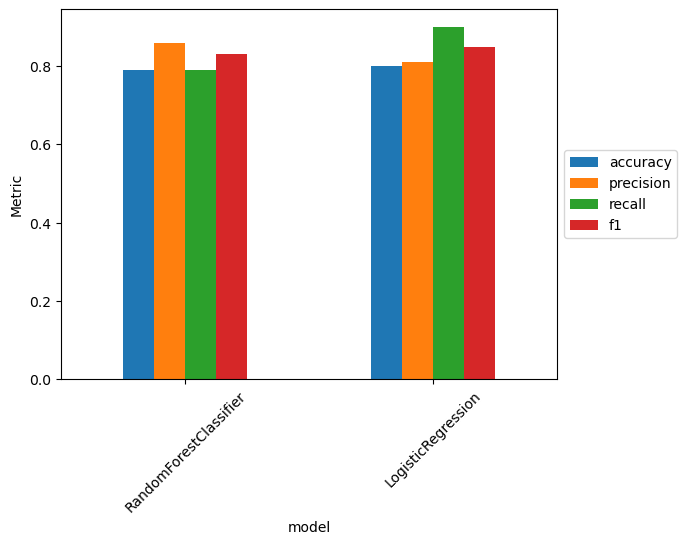

In [15]:
plot_metrics(metric_df)